In [91]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/home/marthen/Documents/Mandiri/Cache/msr.cut.per_10k.rw_40_60.1370.trace', sep=' ', header=None)
df.columns = ['timestamp', 'device', 'offset', 'size', 'read_write']
df = df.drop('device', axis=1)
df.head()

,timestamp,offset,size,read_write
0,0.000,3242508288,4096,0
1,0.000,3242266624,4096,0
2,22.810,2205343744,4096,1
3,45.304,11403917312,512,0
4,45.308,11403917824,512,0


## I/O Operation Distribution

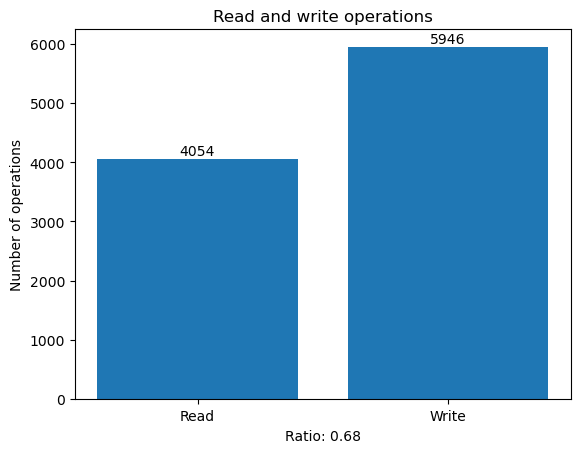

In [92]:
read_ops = df[df['read_write'] == 1]
write_ops = df[df['read_write'] == 0]

fig, ax = plt.subplots()
ax.bar(['Read', 'Write'], [len(read_ops), len(write_ops)])
ax.set_ylabel('Number of operations')
ax.set_title('Read and write operations')

for i, v in enumerate([len(read_ops), len(write_ops)]):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')

ratio = len(read_ops) / len(write_ops)
ax.text(0.5, -0.1, f'Ratio: {ratio:.2f}', ha='center', va='center', transform=ax.transAxes)

plt.show()

### I/O Size Distribution
TODO: total I/O Size

In [93]:
df['size'].describe()

count    10000.000000
mean      4883.558400
std       8490.711393
min        512.000000
25%        512.000000
50%       4096.000000
75%       4096.000000
max      65536.000000
Name: size, dtype: float64

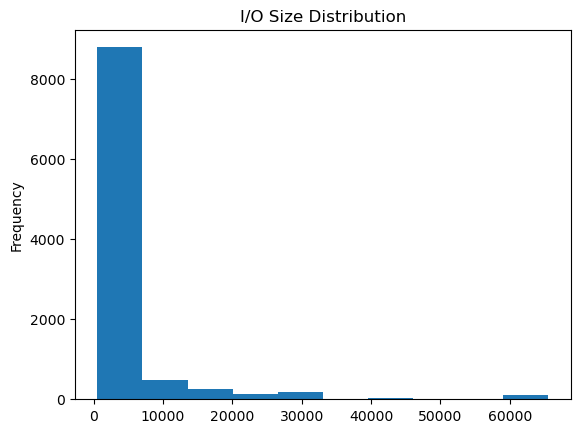

In [94]:
df['size'].plot(kind='hist', bins=10, title='I/O Size Distribution')
plt.show()

### Analyzing Temporal Locality
Time between two accesses to the same location

In [95]:
df_sorted = df.sort_values(['offset', 'timestamp'])
df_sorted['time_diff'] = df_sorted.groupby('offset')['timestamp'].diff()
df_sorted = df_sorted.dropna() # remove na and change to like infinity(?)
df_sorted['time_diff'].describe()

count     4217.000000
mean      2647.903824
std       7557.263870
min          0.000000
25%          0.000000
50%          0.010000
75%       2099.987000
max      73817.821000
Name: time_diff, dtype: float64

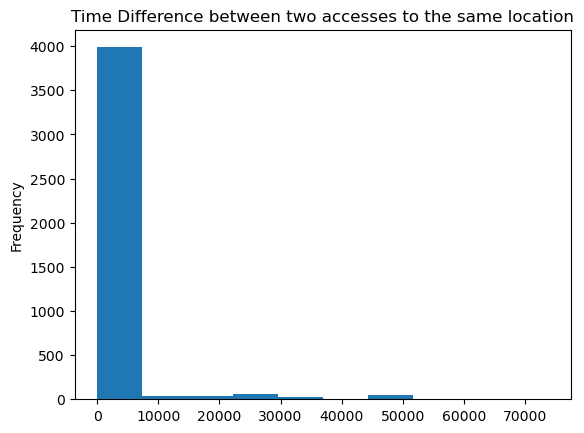

In [96]:
df_sorted['time_diff'].plot(kind='hist', bins=10, title='Time Difference between two accesses to the same location')
plt.show()

### Analyzing Spatial Locality
Access to data locations that are close to each other

In [97]:
df_sorted = df.sort_values(['timestamp', 'offset'])
df_sorted['offset_diff'] = df_sorted['offset'].diff()
df_sorted = df_sorted.dropna()
df_sorted['offset_diff'].describe()

count    9.999000e+03
mean     1.053985e+06
std      3.403393e+09
min     -1.383400e+10
25%     -1.562624e+06
50%      0.000000e+00
75%      7.884800e+06
max      1.479897e+10
Name: offset_diff, dtype: float64

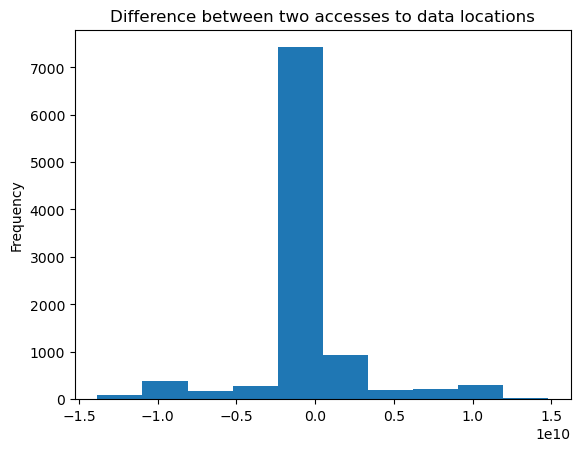

In [98]:
df_sorted['offset_diff'].plot(kind='hist', bins=10, title='Difference between two accesses to data locations')
plt.show()

# IOPS for Read and Write

In [102]:
grouped = df.groupby(['timestamp', 'read_write'])

iops = grouped.size()
read_iops = iops.xs(1, level='read_write')
write_iops = iops.xs(0, level='read_write')
throughput = grouped['size'].sum()
read_throughput = throughput.xs(1, level='read_write')
write_throughput = throughput.xs(0, level='read_write')

iops_series = pd.Series(iops)
iops_series = iops_series * 1e6
read_iops_series = pd.Series(read_iops)
read_iops_series = read_iops_series * 1e6
write_iops_series = pd.Series(write_iops)
write_iops_series = write_iops_series * 1e6
throughput_series = pd.Series(throughput)
throughput_series = throughput_series * 1e6
read_throughput_series = pd.Series(read_throughput)
read_throughput_series = read_throughput_series * 1e6
write_throughput_series = pd.Series(write_throughput)
write_throughput_series = write_throughput_series * 1e6

print('Data in seconds, so IO per seconds and throughput is bytes per second\n')
print(f'IOPS: \n{iops_series.describe()}\n')
print(f'Read IOPS: \n{read_iops_series.describe()}\n')
print(f'Write IOPS: \n{write_iops_series.describe()}\n')
print(f'Throughput: \n{throughput_series.describe()}\n')
print(f'Read Throughput: \n{read_throughput_series.describe()}\n')
print(f'Write Throughput: \n{write_throughput_series.describe()}\n')

Data in seconds, so IO per seconds and throughput is bytes per second

IOPS: 
count    7.240000e+03
mean     1.381077e+06
std      1.173545e+06
min      1.000000e+06
25%      1.000000e+06
50%      1.000000e+06
75%      1.000000e+06
max      1.800000e+07
dtype: float64

Read IOPS: 
count    3.348000e+03
mean     1.210872e+06
std      9.029918e+05
min      1.000000e+06
25%      1.000000e+06
50%      1.000000e+06
75%      1.000000e+06
max      1.100000e+07
dtype: float64

Write IOPS: 
count    3.892000e+03
mean     1.527492e+06
std      1.347018e+06
min      1.000000e+06
25%      1.000000e+06
50%      1.000000e+06
75%      1.000000e+06
max      1.800000e+07
dtype: float64

Throughput: 
count    7.240000e+03
mean     6.744681e+09
std      1.107043e+10
min      5.120000e+08
25%      1.024000e+09
50%      4.096000e+09
75%      4.096000e+09
max      1.802240e+11
Name: size, dtype: float64

Read Throughput: 
count    3.348000e+03
mean     5.835546e+09
std      7.067047e+09
min      5.120000e+0

# Tail Latency

In [100]:
df['latency'] = df['timestamp'].diff()
df = df.dropna()
tail_latency = df['latency'].quantile(0.99)
print(f'Tail Latency: {tail_latency:.2f} microseconds')

Tail Latency: 200.04 microseconds
